## Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import random

## Function that reads the data

In [2]:
def get_data():
    # Path which our data is stored
    path = 'dns_oct-jan.csv'

    data = pd.read_csv(
             path,
             header=0
    )

    # Change to data type to datetime
    data['day'] = pd.to_datetime(data.day)

    # Keep necessary columns
    data = data[['shieldid', 'day', 'dns_qname', 'dns_qdomainname', 'num_clients', 'num_responses']]
    
    # drop the test shieldid
    bad_shield = 'haddomyev'
    data = data[data.shieldid != bad_shield]
    
    return data

In [3]:
data = get_data()

## Function transforms data into df

In [4]:
def get_df(data):    
    
    # df1 sums by domain name and day
    df1 = data.groupby(by=['dns_qdomainname','day']).sum()

    # df2 counts unique query names by domain name and day
    df2 = data.groupby(by=['dns_qdomainname','day'])[['shieldid','dns_qname']].nunique()
    df2 = pd.DataFrame(df2)
    df2.rename(columns={'shieldid': 'num_shieldid', 'dns_qname': 'num_dns_qname'}, inplace=True)
    
    # Concatenate df1 and df2 into df
    df = pd.concat([df1, df2], axis=1)
    df.reset_index(level=1, inplace=True)
    
    # Create Column with Generic popularity
    path = 'https://raw.githubusercontent.com/zer0h/top-1000000-domains/master/top-1000000-domains'
    top_domains = pd.read_csv(path, header=None, names=['dns_qdomainname'])
    rank = list(range(1, 1_000_001))
    top_domains['rank'] = rank
    top_domains.set_index('dns_qdomainname',inplace=True)
    df = df.join(top_domains, on='dns_qdomainname')
    
    # Merge with the transformed whois csv
    import re
    whois = pd.read_csv('whoisv1.csv')
    whois.set_index('domain', inplace=True)
    dfmerged = df.join(whois, on='dns_qdomainname')
    
    # Define data types
    dfmerged['registration_period'] = pd.to_numeric(dfmerged['registration_period'].str.replace(r'\D+', '', regex=True))
    dfmerged['day'] = pd.to_datetime(dfmerged['day'])
    dfmerged['created'] = pd.to_datetime(dfmerged['created'])
    dfmerged['updated'] = pd.to_datetime(dfmerged['updated'])
    dfmerged['expires'] = pd.to_datetime(dfmerged['expires'])
    
    return dfmerged

df = get_df(data)

In [5]:
df.head(5)

,day,num_clients,num_responses,num_shieldid,num_dns_qname,rank,created,updated,expires,whois,registration_period
dns_qdomainname,,,,,,,,,,,
*google.com,2022-10-02,1,2,1,1,NaN,NaT,NaT,NaT,NaN,NaN
*google.com,2022-10-03,1,2,1,1,NaN,NaT,NaT,NaT,NaN,NaN
*google.com,2022-10-04,1,2,1,1,NaN,NaT,NaT,NaT,NaN,NaN
*google.com,2022-10-10,1,1,1,1,NaN,NaT,NaT,NaT,NaN,NaN
*google.com,2022-10-11,3,115,2,1,NaN,NaT,NaT,NaT,NaN,NaN


In [6]:
def bin_and_merge(df, group_col, bin_col, bin_label):
    # Group by domain and sum the values for the given column
    group_by_domain = df.groupby(df.index)[bin_col].sum().reset_index()

    # Sort the data by ascending order
    group_by_domain.sort_values(by=bin_col, inplace=True)

    # Create the bin edges for 5 equal cuts
    bin_edges_a = pd.qcut(group_by_domain[bin_col], q=group_by_domain[bin_col].nunique(), duplicates='drop').sort_values().unique()

    # Create the bin labels
    bin_labels = [f"{int(bin_edges_a[i].left+1)}-{int(bin_edges_a[i].right)}" for i in range(len(bin_edges_a))]

    # Convert bin edges to floats
    bin_edges = [float(bin_edge.left) for bin_edge in bin_edges_a]
    bin_edges.append(float(bin_edges_a[-1].right))

    # Bin the data and assign the labels to each row
    group_by_domain['group'] = pd.cut(group_by_domain[bin_col], bins=bin_edges, labels=bin_labels)

    # Merge the labeled data back to the original dataframe
    df = pd.merge(df, group_by_domain[['dns_qdomainname', 'group']], on='dns_qdomainname', how='left')
    df.rename(columns={'group': bin_label}, inplace=True)
    df.set_index('dns_qdomainname', inplace=True)

    return df

# Apply the binning to different columns
df = bin_and_merge(df, 'dns_qdomainname', 'num_clients', 'client_sum_group')
df = bin_and_merge(df, 'dns_qdomainname', 'num_responses', 'responses_sum_group')
df = bin_and_merge(df, 'dns_qdomainname', 'num_shieldid', 'shield_sum_group')

In [7]:
import time
start_time = time.time()

# list the sum groups
sum_groups = [
    ("client_sum_group", "num_clients", "prob_obs_num_clients"),
    ("responses_sum_group", "num_responses", "prob_obs_num_responses"),
    ("shield_sum_group", "num_shieldid", "prob_obs_num_shield")
]

for group_col, num_col, prob_col in sum_groups:
    # loop over each sum group
    for group_val in df[group_col].sort_values().unique():
        # empty dictionary
        dict_ = {}
        # slice the df to sum group
        case = df.loc[df[group_col]==group_val]
        # create the number of bins so we get discrete bins
        num_bins = case[num_col].max()
        # cumulative distribution of the empirical observations
        pds, bins = np.histogram(case[num_col], bins=num_bins, density=False)
        probs = list(1 - (pds/np.sum(pds)).cumsum())
        probs.insert(0,1)
        probs.pop(-1)
        probs = np.array(probs)
        # list the integer bin values
        bins = list(bins)
        for i in range(len(bins)):
            bins[i] = int(i)
        bins.pop(0)
        bins = np.array(bins)
        if len(bins) == len(probs):
            # create dictionary
            dict_ = dict(zip(bins, probs))
            # replace the values in the column with dictionary values using apply
            df.loc[df[group_col] == group_val, prob_col] = case[num_col].apply(lambda x: dict_.get(int(x), 0))
            
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 124.7292730808258 seconds


# Issue with overreporting anomalies on days with high traffic

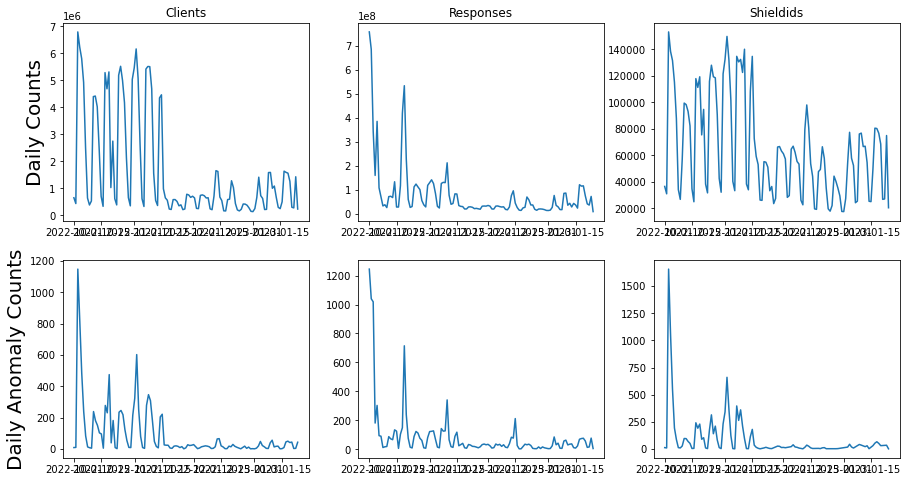

In [78]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
abc = df.groupby('day').num_clients.sum()
ax[0,0].plot(abc)
ax[0,0].set_title('Clients')
ax[0,0].set_ylabel('Daily Counts', fontsize=20)
abc = df.groupby('day').num_responses.sum()
ax[0,1].plot(abc)
ax[0,1].set_title('Responses')
abc = df.groupby('day').num_shieldid.sum()
ax[0,2].plot(abc)
ax[0,2].set_title('Shieldids')
ax[1,0].set_ylabel('Daily Anomaly Counts', fontsize=20)
abc = df.sort_values(by='prob_obs_num_clients').head(10000).day.value_counts().sort_index()
ax[1,0].plot(abc.index, abc)
abc = df.sort_values(by='prob_obs_num_responses').head(10000).day.value_counts().sort_index()
ax[1,1].plot(abc.index, abc)
abc = df.sort_values(by='prob_obs_num_shield').head(10000).day.value_counts().sort_index()
ax[1,2].plot(abc.index, abc)
plt.show()

In [181]:
lengthdf = df.shape[0]
df['client_norm'] = np.ones(lengthdf)
period = df.day.nunique()
totalclients = df.num_clients.sum()
days = list(sorted(df.day.unique()))
for day in days:
    daily = df.loc[df.day==day]['num_clients'].sum()
    df.loc[df.day==day, 'client_norm'] = df.loc[df.day==day, 'prob_obs_num_clients'] * daily / totalclients * period

In [182]:
df['response_norm'] = np.ones(lengthdf)
totalresponses = df.num_responses.sum()
for day in days:
    daily = df.loc[df.day==day]['num_responses'].sum()
    df.loc[df.day==day, 'response_norm'] = df.loc[df.day==day, 'prob_obs_num_responses'] * daily / totalresponses * period

In [183]:
df['shieldid_norm'] = np.ones(lengthdf)
totalshieldids = df.num_shieldid.sum()
for day in days:
    daily = df.loc[df.day==day]['num_shieldid'].sum()
    df.loc[df.day==day, 'shieldid_norm'] = df.loc[df.day==day, 'prob_obs_num_shield'] * daily / totalshieldids * period

## After normalizing

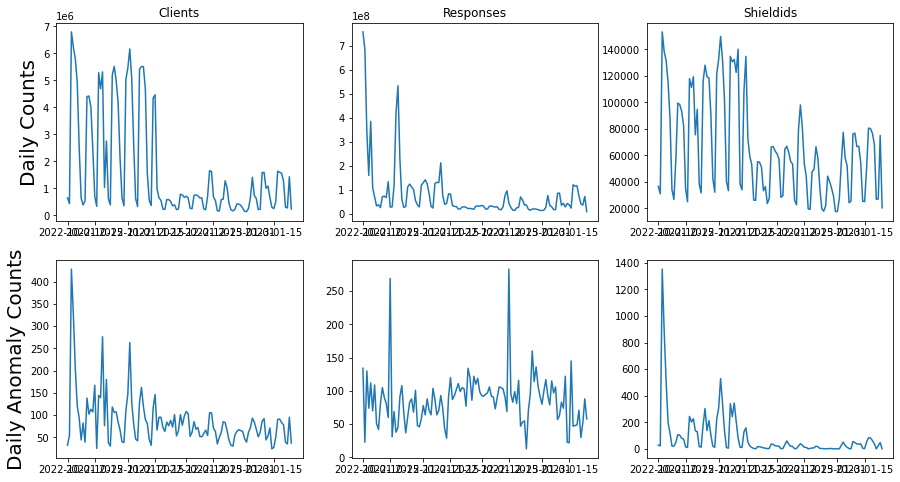

In [184]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
abc = df.groupby('day').num_clients.sum()
ax[0,0].plot(abc)
ax[0,0].set_title('Clients')
ax[0,0].set_ylabel('Daily Counts', fontsize=20)
abc = df.groupby('day').num_responses.sum()
ax[0,1].plot(abc)
ax[0,1].set_title('Responses')
abc = df.groupby('day').num_shieldid.sum()
ax[0,2].plot(abc)
ax[0,2].set_title('Shieldids')
ax[1,0].set_ylabel('Daily Anomaly Counts', fontsize=20)
abc = df.sort_values(by='client_norm').head(10000).day.value_counts().sort_index()
ax[1,0].plot(abc.index, abc)
abc = df.sort_values(by='response_norm').head(10000).day.value_counts().sort_index()
ax[1,1].plot(abc.index, abc)
abc = df.sort_values(by='shieldid_norm').head(10000).day.value_counts().sort_index()
ax[1,2].plot(abc.index, abc)
plt.show()

# Now, ranking anomalies: 0 is anomaly, 1 is normal.

In [185]:
lengthdf = len(df)
ranks = np.linspace(0,1,lengthdf)
df.sort_values(by='client_norm', inplace=True)
df['client_norm'] = ranks
df.sort_values(by='response_norm', inplace=True)
df['response_norm'] = ranks
df.sort_values(by='shieldid_norm', inplace=True)
df['shieldid_norm'] = ranks
df.sort_index(inplace=True)
df['normal_obs'] = df.client_norm*df.response_norm*df.shieldid_norm
df.sort_values(by='normal_obs', inplace=True)
df['normalobs'] = ranks

In [186]:
cutoff = .01
top_anoms= df.sort_values(by='normal_obs').head(int(cutoff*lengthdf))

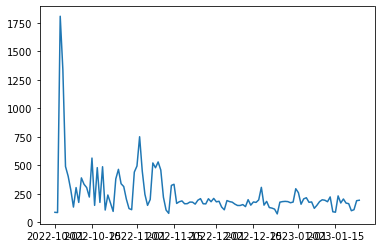

In [187]:
abc = top_anoms.day.value_counts().sort_index()
plt.plot(abc)

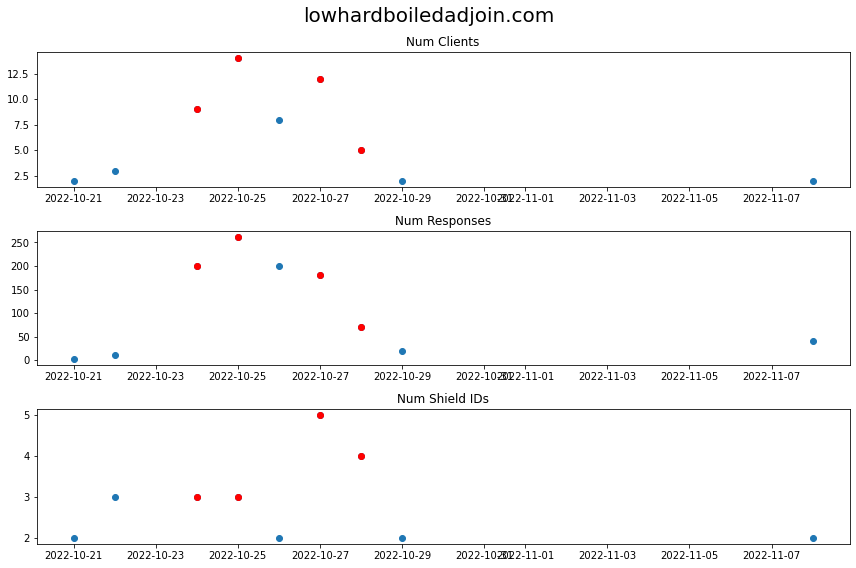

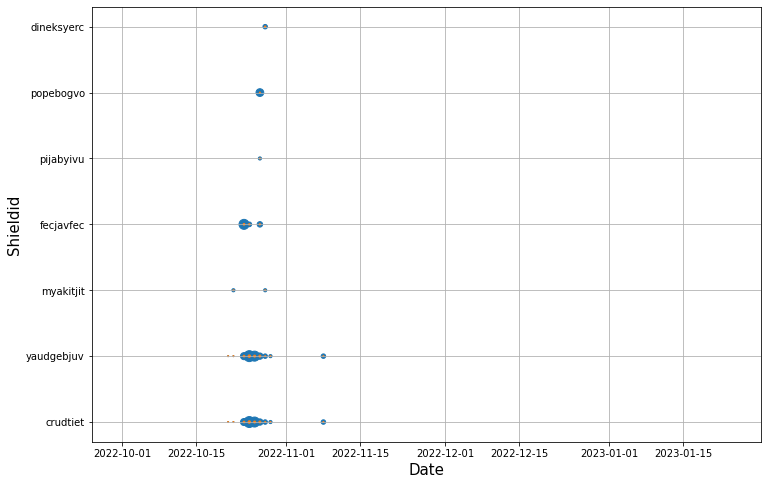

In [347]:
rs = random.sample(list(top_anoms.index.unique()),1)
domain = 'lowhardboiledadjoin.com'
test = df.loc[df.index==domain]
dom_anoms = top_anoms.loc[top_anoms.index==domain]

fig, axs = plt.subplots(3, 1, figsize=(12, 8))

axs[0].scatter(test.day, test.num_clients)
axs[0].set_title('Num Clients')
axs[0].scatter(dom_anoms.day, dom_anoms.num_clients, color='red')

axs[1].scatter(test.day, test.num_responses)
axs[1].set_title('Num Responses')
axs[1].scatter(dom_anoms.day, dom_anoms.num_responses, color='red')

axs[2].scatter(test.day, test.num_shieldid)
axs[2].set_title('Num Shield IDs')
axs[2].scatter(dom_anoms.day, dom_anoms.num_shieldid, color='red')

plt.suptitle(str(domain), fontsize=20)
plt.tight_layout()
plt.show()

def get_domain_case_new(data, domain_name):    
    
    datatemp = data.loc[data.dns_qdomainname==domain_name]
    
    # df1 sums by domain name and day
    df1 = datatemp.groupby(by=['dns_qdomainname','day','shieldid']).sum()

    # df2 counts unique query names by domain name and day
    df2 = datatemp.groupby(by=['dns_qdomainname','day','shieldid'])['dns_qname'].nunique()
    df2 = pd.DataFrame(df2)
    df2.rename(columns={'dns_qname': 'num_dns_qname'}, inplace=True)

    # Concatenate df1 and df2 into df
    domain_case_new = pd.concat([df1, df2], axis=1)
    domain_case_new.reset_index(level=1, inplace=True)
    domain_case_new.reset_index(level=1, inplace=True)
    
    from itertools import product

    # Create lists of all unique values in columns 
    l1 = [domain_name]
    l2 = list(data.day.unique())
    l3 = list(domain_case_new.shieldid.unique())
    l4 = [0]
    l5 = [0]
    l6 = [0]

    _ = pd.DataFrame(list(product(l1, l2, l3, l4, l5, l6)), columns=['dns_qdomainname', 'day', 'shieldid', 'num_clients', 'num_responses', 'num_dns_qname'])
    _.set_index(list(_)[0], inplace=True)

    domain_case_new = pd.concat([domain_case_new, _])

    domain_case_new = domain_case_new.sort_values('day')

    return domain_case_new

domain_case_new = get_domain_case_new(data, domain)

# Plot
plt.figure(figsize=(12,8))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Shieldid', fontsize=15)

plt.scatter(domain_case_new.day, domain_case_new.shieldid, s=domain_case_new.num_responses)
plt.scatter(domain_case_new.day, domain_case_new.shieldid, s=domain_case_new.num_clients)
plt.grid(axis='both')

In [339]:
df[['day','num_clients', 'num_responses', 'num_shieldid', 
    'client_sum_group', 'responses_sum_group', 'shield_sum_group',
    'client_norm', 'response_norm', 'shieldid_norm', 'normal_obs']]

,day,num_clients,num_responses,num_shieldid,client_sum_group,responses_sum_group,shield_sum_group,client_norm,response_norm,shieldid_norm,normal_obs
dns_qdomainname,,,,,,,,,,,
ketchcdn.com,2023-01-05,39,606,19,1522-1579,22675-23133,487-540,0.026634,0.030147,0.000000,0.000000e+00
dnethome.net,2022-12-10,1,34060,1,20-20,74195-76417,20-20,0.168894,0.000000,0.238092,3.485553e-07
backblaze.com,2022-12-25,1928,5770,1,18246-21349,400542-433484,102-103,0.000000,0.041282,0.113927,6.971107e-07
bicycling.com,2022-11-17,44,840,8,102-102,1297-1302,36-36,0.000015,0.000178,0.000006,1.045666e-06
knsso.com,2022-11-18,17,85,8,21-21,101-101,12-12,0.000029,0.000333,0.000005,1.394221e-06
...,...,...,...,...,...,...,...,...,...,...,...
clear.sale,2022-10-03,1,1,1,5-5,5-5,5-5,0.998503,0.987430,0.999976,9.999986e-01
fram.com,2022-10-03,1,1,1,9-9,10-10,7-7,0.998504,0.987434,0.999972,9.999990e-01
ccbjournal.com,2022-10-03,1,1,1,34-34,62-62,16-16,0.998589,0.987375,0.999948,9.999993e-01


In [345]:
df.loc[df.index=='lowhardboiledadjoin.com'].sort_values(by='day')

,day,num_clients,num_responses,num_shieldid,num_dns_qname,rank,created,updated,expires,whois,...,client_sum_group,responses_sum_group,shield_sum_group,prob_obs_num_clients,prob_obs_num_responses,prob_obs_num_shield,client_norm,response_norm,shieldid_norm,normal_obs
dns_qdomainname,,,,,,,,,,,,,,,,,,,,,
lowhardboiledadjoin.com,2022-10-21,2,2,2,1,NaN,2022-10-21,2022-10-21,2023-10-21,whois.enom.com,...,57-57,985-989,26-26,0.683008,0.970075,0.300666,0.778177,0.743096,0.280761,0.625425
lowhardboiledadjoin.com,2022-10-22,3,12,3,1,NaN,2022-10-21,2022-10-21,2023-10-21,whois.enom.com,...,57-57,985-989,26-26,0.344290,0.554239,0.032707,0.137013,0.240706,0.004837,0.023384
lowhardboiledadjoin.com,2022-10-24,9,200,3,1,NaN,2022-10-21,2022-10-21,2023-10-21,whois.enom.com,...,57-57,985-989,26-26,0.017409,0.009975,0.032707,0.032433,0.010242,0.015557,0.003936
lowhardboiledadjoin.com,2022-10-25,14,262,3,1,NaN,2022-10-21,2022-10-21,2023-10-21,whois.enom.com,...,57-57,985-989,26-26,0.004875,0.003741,0.032707,0.007429,0.003650,0.016937,0.001261
lowhardboiledadjoin.com,2022-10-26,8,200,2,1,NaN,2022-10-21,2022-10-21,2023-10-21,whois.enom.com,...,57-57,985-989,26-26,0.028552,0.009975,0.300666,0.067368,0.010238,0.384123,0.030795
lowhardboiledadjoin.com,2022-10-27,12,180,5,1,NaN,2022-10-21,2022-10-21,2023-10-21,whois.enom.com,...,57-57,985-989,26-26,0.007660,0.011222,0.000720,0.009169,0.010388,0.000386,0.000459
lowhardboiledadjoin.com,2022-10-28,5,70,4,1,NaN,2022-10-21,2022-10-21,2023-10-21,whois.enom.com,...,57-57,985-989,26-26,0.098886,0.066708,0.004621,0.135296,0.038295,0.001674,0.005105
lowhardboiledadjoin.com,2022-10-29,2,20,2,1,NaN,2022-10-21,2022-10-21,2023-10-21,whois.enom.com,...,57-57,985-989,26-26,0.683008,0.372195,0.300666,0.349098,0.219202,0.065152,0.155449
lowhardboiledadjoin.com,2022-11-08,2,40,2,1,NaN,2022-10-21,2022-10-21,2023-10-21,whois.enom.com,...,57-57,985-989,26-26,0.683008,0.172070,0.300666,0.902305,0.410921,0.423153,0.619004


In [350]:
df.columns

Index(['day', 'num_clients', 'num_responses', 'num_shieldid', 'num_dns_qname',
       'rank', 'created', 'updated', 'expires', 'whois', 'registration_period',
       'client_sum_group', 'responses_sum_group', 'shield_sum_group',
       'prob_obs_num_clients', 'prob_obs_num_responses', 'prob_obs_num_shield',
       'client_norm', 'response_norm', 'shieldid_norm', 'normal_obs'],
      dtype='object')

In [346]:
df.to_csv('all_anom_probs')

In [352]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures

In [417]:
X = df[['rank', 'whois', 'registration_period']]
y = df['normal_obs']

In [360]:
# regression pipeline
cat_features = ['whois']
num_features = ['rank', 'registration_period']

cat_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('encoder', OneHotEncoder())
])

num_processor = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

feature_processor = ColumnTransformer(
    transformers=[
        ('categorical processor', cat_processor, cat_features),
        ('numerical processor', num_processor, num_features)
]
    ,remainder='drop')
    
pipe = Pipeline(steps=[
    ('feature_processor',feature_processor),
    ('poly_features',PolynomialFeatures(degree=1)),
    ('regression',LinearRegression())
])

# fit the model to training set
pipe.fit(X_train,y_train)

SyntaxError: invalid syntax (2807982256.py, line 6)